In [139]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/language-learning/Dataset/english-corpus.txt
/kaggle/input/language-learning/Dataset/urdu-corpus.txt


In [140]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import seaborn as sns
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [141]:
# Adjust this if the folder name is different in your "Add Data"
urdu = []
with open('/kaggle/input/language-learning/Dataset/urdu-corpus.txt', 'r', encoding="utf8") as f:
    urdu = f.readlines()

english = []
with open('/kaggle/input/language-learning/Dataset/english-corpus.txt', 'r', encoding="utf8") as f:
    english = f.readlines()

import pandas as pd

# Strip whitespace/newlines and zip into a DataFrame
data = pd.DataFrame(list(zip([line.strip() for line in english],
                             [line.strip() for line in urdu])), 
                    columns=['english', 'urdu'])


**PreProcesing**

In [142]:
import re

def expand_contractions(text):
    contractions = {
        "won't": "will not",
        "can't": "can not",
        "won\’t": "will not",
        "can\’t": "can not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am",
        "\’re": " are",
        "\’s": " is",
        "\’d": " would",
        "\’ll": " will",
        "\’t": " not",
        "\’ve": " have",
        "\’m": " am"
    }
    for contraction, full_form in contractions.items():
        text = text.replace(contraction, full_form)
    return text

def preprocess_english(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'[$-)\"’°;\'€%:(/]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def preprocess_other_language(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'[$)\"’°!;\'€%:(/]', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'-', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

data['english'] = data['english'].apply(preprocess_english)
data['urdu'] = data['urdu'].apply(preprocess_other_language)

# Simple data augmentation: swap source and target
aug_data = data.copy()
aug_data.columns = ['urdu', 'english']  # Reverse roles
aug_data = aug_data.sample(frac=0.2, random_state=42)

# Combine with original
data = pd.concat([data, aug_data]).reset_index(drop=True)
print("✅ Dataset size after augmentation:", len(data))

data = data[data['urdu'].str.split().apply(len) < 40]
data = data[data['english'].str.split().apply(len) < 40]

data = data.drop(columns=['urdu_len', 'english_len'], errors='ignore')

data.head()


✅ Dataset size after augmentation: 29430


,english,urdu
0,is zain your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔


In [143]:

from tensorflow.keras.preprocessing.text import Tokenizer

# Urdu tokenizer using Keras Tokenizer (not BERT)
urdu_tokenizer = Tokenizer(num_words=8000, oov_token="<OOV>")
urdu_tokenizer.fit_on_texts(data['urdu'])
data['urdu_tokens'] = urdu_tokenizer.texts_to_sequences(data['urdu'])


In [144]:
train_examples =  tf.data.Dataset.from_tensor_slices((data['english'].values, data['urdu'].values))

In [145]:
BATCH_SIZE = 32
MAX_LENGTH = 50
def make_batches(ds):
  return (
      ds
      .cache()
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)

for i in train_examples:
  print(i)
  break

(<tf.Tensor: shape=(), dtype=string, numpy=b'is zain your nephew'>, <tf.Tensor: shape=(), dtype=string, numpy=b'\xd8\xb2\xdb\x8c\xd9\x86 \xd8\xaa\xd9\x85\xdb\x81\xd8\xa7\xd8\xb1\xd8\xa7 \xd8\xa8\xda\xbe\xd8\xaa\xdb\x8c\xd8\xac\xd8\xa7 \xdb\x81\xdb\x92\xdb\x94'>)


In [146]:
# Learning rate schedule + optimizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model=512)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


(1, 50, 512)


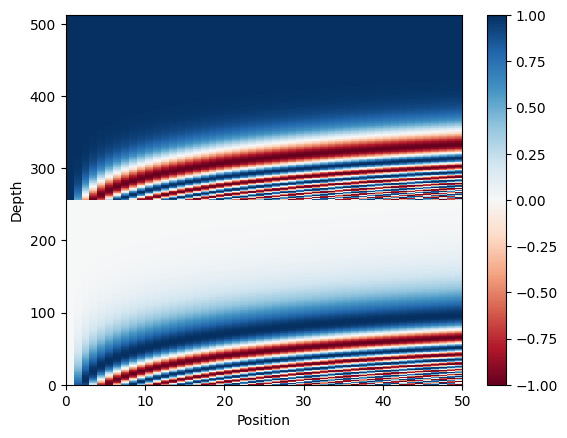

In [147]:

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

n, d = MAX_LENGTH, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

pos_encoding = tf.reshape(pos_encoding, (n, d // 2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    
    # Compute the dot product of the query and key
    scaled_attention_logits = tf.matmul(q, k, transpose_b=True)  # [batch_size, num_heads, target_seq_len, target_seq_len]
    
    # Apply the mask if provided
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # Apply mask to logits, ensuring the masked positions are set to a very negative value

    # Compute the attention weights using softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # Compute the output as a weighted sum of the value (v) tensor
    output = tf.matmul(attention_weights, v)  # [batch_size, num_heads, target_seq_len, d_model]
    
    return output, attention_weights



class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Transformer

In [148]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape
     

TensorShape([64, 50, 512])

In [149]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # Explicitly pass arguments as keyword arguments
        attn_output, _ = self.mha(q=x, k=x, v=x, mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# Call the encoder layer
sample_encoder_layer_output = sample_encoder_layer(
    x=tf.random.uniform((64, 43, 512)), training=False, mask=None
)

print(sample_encoder_layer_output.shape)  # Expected: (64, 43, 512)


(64, 43, 512)


In [150]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # Corrected to use keyword arguments
        attn1, attn_weights_block1 = self.mha1(q=x, k=x, v=x, mask=look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # Corrected to use keyword arguments
        attn2, attn_weights_block2 = self.mha2(
            q=out1, k=enc_output, v=enc_output, mask=padding_mask
        )  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2


In [151]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# Call the decoder layer
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    x=tf.random.uniform((64, 50, 512)),  # Target sequence
    enc_output=sample_encoder_layer_output,  # Encoder output
    training=False,
    look_ahead_mask=None,
    padding_mask=None
)

print(sample_decoder_layer_output.shape)  # Expected: (64, 50, 512)


(64, 50, 512)


In [152]:
class AlternateEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(AlternateEncoder, self).__init__()

        # Storing parameters
        self.d_model = d_model
        self.num_layers = num_layers

        # Layers
        self.embedding_layer = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.positional_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout_layer = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # Determine the sequence length from the input
        seq_len = tf.shape(x)[1]

        # Embedding and scaling
        embedded_input = self.embedding_layer(x)  # (batch_size, input_seq_len, d_model)
        embedded_input *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # Add positional encoding
        positional_encoded_input = embedded_input + self.positional_encoding[:, :seq_len, :]

        # Apply dropout
        output = self.dropout_layer(positional_encoded_input, training=training)

        # Pass through each encoder layer
        for layer in self.encoder_layers:
            output = layer(output, training=training, mask=mask)

        return output  # (batch_size, input_seq_len, d_model)


In [153]:
alternate_encoder = AlternateEncoder(
    num_layers=2, 
    d_model=512, 
    num_heads=8, 
    dff=2048, 
    input_vocab_size=8500, 
    maximum_position_encoding=10000
)

# Input tensor
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

# Encoder output
alternate_encoder_output = alternate_encoder(temp_input, training=False, mask=None)

print(alternate_encoder_output.shape)  # Expected output: (64, 62, 512)


(64, 62, 512)


In [154]:
class AlternateDecoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(AlternateDecoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding_layer = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.positional_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout_layer = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]

        embedded_input = self.embedding_layer(x)  # (batch_size, target_seq_len, d_model)
        embedded_input *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        positional_encoded_input = embedded_input + self.positional_encoding[:, :seq_len, :]

        output = self.dropout_layer(positional_encoded_input, training=training)

        attention_weights = {}
        for i, layer in enumerate(self.decoder_layers):

            output, block1, block2 = layer(
                x=output,  # Target sequence
                enc_output=enc_output,  # Encoder output
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

            attention_weights[f"decoder_layer{i+1}_block1"] = block1
            attention_weights[f"decoder_layer{i+1}_block2"] = block2

        return output, attention_weights  # (batch_size, target_seq_len, d_model), attention weights


alternate_decoder = AlternateDecoder(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    target_vocab_size=8000,
    maximum_position_encoding=5000
)


temp_target = tf.random.uniform((64, 50), dtype=tf.int64, minval=0, maxval=8000)


alternate_decoder_output, attention_weights = alternate_decoder(
    x=temp_target,
    enc_output=alternate_encoder_output,
    training=False,
    look_ahead_mask=None,
    padding_mask=None
)

print(alternate_decoder_output.shape) 


(64, 50, 512)


In [155]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        # Replacing with AlternateEncoder and AlternateDecoder
        self.tokenizer = AlternateEncoder(num_layers, d_model, num_heads, dff,
                                          input_vocab_size, pe_input, rate)
        
        self.decoder = AlternateDecoder(num_layers, d_model, num_heads, dff,
                                        target_vocab_size, pe_target, rate)

        # Final dense layer for output
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        # Pass input through the encoder (AlternateEncoder)
        enc_output = self.tokenizer(inp, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # Pass target and encoder output through the decoder (AlternateDecoder)
        dec_output, attention_weights = self.decoder(
            x=tar, enc_output=enc_output, training=training, 
            look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        # Apply the final dense layer for output prediction
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

# Instantiate the Transformer model with updated encoder and decoder
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000
)

# Sample input and target sequences
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

# Perform the forward pass
fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print(fn_out.shape)  # Expected: (64, 36, 8000)


(64, 36, 8000)


In [156]:

from tensorflow.keras.preprocessing.text import Tokenizer

# Urdu tokenizer using Keras Tokenizer (not BERT)
urdu_tokenizer = Tokenizer(num_words=8000, oov_token="<OOV>")
urdu_tokenizer.fit_on_texts(data['urdu'])
data['urdu_tokens'] = urdu_tokenizer.texts_to_sequences(data['urdu'])


In [157]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the loss function and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # Mask out padding tokens and calculate loss
    mask = tf.math.logical_not(tf.equal(real, 0))  # Pad tokens have value 0
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # Average loss per non-padded token

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [158]:
# Define the training step function
@tf.function
def train_step(inp, tar, transformer, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    with tf.GradientTape() as tape:
        # Forward pass through the transformer model
        predictions, _ = transformer(inp, tar, training=True,
                                     enc_padding_mask=enc_padding_mask,
                                     look_ahead_mask=look_ahead_mask,
                                     dec_padding_mask=dec_padding_mask)
        # Calculate the loss
        loss = loss_function(tar, predictions)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # Apply gradient clipping
    clipped_gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
    optimizer.apply_gradients(zip(clipped_gradients, transformer.trainable_variables))


    return loss



In [159]:
def create_masks(inp, tar):
    # Padding mask for the encoder (enc_padding_mask)
    enc_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)  # Mask padding tokens in the input
    # Padding mask for the decoder (dec_padding_mask)
    dec_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)  # Mask padding tokens in the encoder output
    
    # Look-ahead mask for the decoder (look_ahead_mask)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((tf.shape(tar)[1], tf.shape(tar)[1])), -1, 0)  # Prevent peeking

    # Expand the look-ahead mask to match attention head dimensions
    look_ahead_mask = tf.expand_dims(look_ahead_mask, axis=0)  # (1, seq_len, seq_len)
    look_ahead_mask = tf.expand_dims(look_ahead_mask, axis=1)  # (1, 1, seq_len, seq_len)
    look_ahead_mask = tf.tile(look_ahead_mask, [tf.shape(inp)[0], 8, 1, 1])  # (batch_size, num_heads, seq_len, seq_len)

    # Ensure proper shapes for the masks
    enc_padding_mask = tf.expand_dims(enc_padding_mask, axis=1)  # (batch_size, 1, seq_len)
    enc_padding_mask = tf.expand_dims(enc_padding_mask, axis=2)  # (batch_size, 1, 1, seq_len)
    dec_padding_mask = tf.expand_dims(dec_padding_mask, axis=1)  # (batch_size, 1, seq_len)
    dec_padding_mask = tf.expand_dims(dec_padding_mask, axis=2)  # (batch_size, 1, 1, seq_len)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask


# Prepare the dataset
BATCH_SIZE = 64
MAX_LENGTH = 50

en_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data['english_tokens'] = data['english'].apply(lambda x: en_tokenizer.encode(x, add_special_tokens=True))

en_padded = pad_sequences(data["english_tokens"], maxlen=MAX_LENGTH, padding='post', truncating='post')
ur_padded = pad_sequences(data["urdu_tokens"], maxlen=MAX_LENGTH, padding='post', truncating='post')

train_examples = tf.data.Dataset.from_tensor_slices((en_padded, ur_padded))


In [160]:
import tensorflow as tf

# === 1. Define loss and optimizer BEFORE training starts ===
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(inp, tar, transformer, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar, training=True,
                                     enc_padding_mask=enc_padding_mask,
                                     look_ahead_mask=look_ahead_mask,
                                     dec_padding_mask=dec_padding_mask)
        loss = loss_function(tar, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # Apply gradient clipping
    clipped_gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
    optimizer.apply_gradients(zip(clipped_gradients, transformer.trainable_variables))

    return loss

# === 2. Dataset prep ===
def make_batches(ds):
    return ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_batches = make_batches(train_examples)

BATCH_SIZE = 8                 # Start small to avoid OOM
MAX_LENGTH = 50
EPOCHS = 10

transformer = Transformer(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    input_vocab_size=30522,
    target_vocab_size=8000,  # or 119547 if GPU allows
    pe_input=MAX_LENGTH,
    pe_target=MAX_LENGTH
)

# === 4. Training loop ===
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0

    for step, (inp, tar) in enumerate(train_batches):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        batch_loss = train_step(inp, tar, transformer, enc_padding_mask, look_ahead_mask, dec_padding_mask)
        total_loss += batch_loss

        if step % 10 == 0:
            print(f"Step {step}: Loss = {batch_loss.numpy()}")

    avg_loss = total_loss / (step + 1)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_loss.numpy()}")
    transformer.save_weights(f"/kaggle/working/transformer_epoch_{epoch + 1}.weights.h5")
    print(f"Model weights saved at epoch {epoch + 1}")


Epoch 1/10
Step 0: Loss = 9.051582336425781
Step 10: Loss = 8.051912307739258
Step 20: Loss = 7.447792053222656
Step 30: Loss = 6.8374552726745605
Step 40: Loss = 6.108687400817871
Step 50: Loss = 5.553360939025879
Step 60: Loss = 5.107004165649414
Step 70: Loss = 4.74232816696167
Step 80: Loss = 4.476678848266602
Step 90: Loss = 4.417648792266846
Step 100: Loss = 3.7124617099761963
Step 110: Loss = 3.4681453704833984
Step 120: Loss = 3.2324507236480713
Step 130: Loss = 3.404010057449341
Step 140: Loss = 2.7731235027313232
Step 150: Loss = 2.587160110473633
Step 160: Loss = 2.7680695056915283
Step 170: Loss = 2.639176607131958
Step 180: Loss = 2.5013668537139893
Step 190: Loss = 2.493377685546875
Step 200: Loss = 2.481670379638672
Step 210: Loss = 2.3139028549194336
Step 220: Loss = 2.3963515758514404
Step 230: Loss = 2.337888240814209
Step 240: Loss = 1.9925860166549683
Step 250: Loss = 2.0741701126098633
Step 260: Loss = 1.9001023769378662
Step 270: Loss = 1.9104459285736084
Step 280

In [161]:
def loss_function(real, pred):
    # Mask out padding tokens and calculate loss
    mask = tf.math.logical_not(tf.equal(real, 0))  # Pad tokens have value 0
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)  # Average loss per non-padded token

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)



In [162]:
@tf.function
def train_step(inp, tar, transformer, enc_padding_mask, look_ahead_mask, dec_padding_mask):
    with tf.GradientTape() as tape:
        # Forward pass through the transformer model
        predictions, _ = transformer(inp, tar, training=True,
                                     enc_padding_mask=enc_padding_mask,
                                     look_ahead_mask=look_ahead_mask,
                                     dec_padding_mask=dec_padding_mask)
        # Calculate the loss
        loss = loss_function(tar, predictions)

    # Compute gradients and apply them
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # Apply gradient clipping
    clipped_gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
    optimizer.apply_gradients(zip(clipped_gradients, transformer.trainable_variables))


    return loss


In [163]:
print(type(data['english_tokens'].iloc[0]))
print(data['english_tokens'].iloc[0])


<class 'list'>
[101, 2003, 23564, 2378, 2115, 7833, 102]


In [164]:
def create_masks(inp, tar):
    # Padding mask for the encoder (enc_padding_mask)
    enc_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)  # Mask padding tokens in the input
    # Padding mask for the decoder (dec_padding_mask)
    dec_padding_mask = tf.cast(tf.math.equal(inp, 0), tf.float32)  # Mask padding tokens in the encoder output
    
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((tf.shape(tar)[1], tf.shape(tar)[1])), -1, 0)  # Prevent peeking

    look_ahead_mask = tf.expand_dims(look_ahead_mask, axis=0)  # (1, seq_len, seq_len)
    look_ahead_mask = tf.expand_dims(look_ahead_mask, axis=1)  # (1, 1, seq_len, seq_len)
    look_ahead_mask = tf.tile(look_ahead_mask, [tf.shape(inp)[0], 8, 1, 1])  # (batch_size, num_heads, seq_len, seq_len)

    # Ensure proper shapes for the masks
    enc_padding_mask = tf.expand_dims(enc_padding_mask, axis=1)  # (batch_size, 1, seq_len)
    enc_padding_mask = tf.expand_dims(enc_padding_mask, axis=2)  # (batch_size, 1, 1, seq_len)
    dec_padding_mask = tf.expand_dims(dec_padding_mask, axis=1)  # (batch_size, 1, seq_len)
    dec_padding_mask = tf.expand_dims(dec_padding_mask, axis=2)  # (batch_size, 1, 1, seq_len)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask


BATCH_SIZE = 64
MAX_LENGTH = 50


en_padded = pad_sequences(data["english_tokens"], maxlen=MAX_LENGTH, padding='post', truncating='post')
ur_padded = pad_sequences(data["urdu_tokens"], maxlen=MAX_LENGTH, padding='post', truncating='post')

# Create TensorFlow dataset
train_examples = tf.data.Dataset.from_tensor_slices((en_padded, ur_padded))


In [165]:

def make_batches(ds):
    return ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_batches = make_batches(train_examples)

transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=MAX_LENGTH, pe_target=MAX_LENGTH
)

epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0

    for step, (inp, tar) in enumerate(train_batches):
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)

        batch_loss = train_step(inp, tar, transformer, enc_padding_mask, look_ahead_mask, dec_padding_mask)
        total_loss += batch_loss

        if step % 10 == 0:  # Log every 10 steps
            print(f"Step {step}: Loss = {batch_loss.numpy()}")

    avg_loss = total_loss / (step + 1)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_loss.numpy()}")

    transformer.save_weights(f"/kaggle/working/transformer_epoch_{epoch + 1}.weights.h5")
    print(f"Model weights saved at epoch {epoch + 1}")


Epoch 1/10
Step 0: Loss = 9.031786918640137
Step 10: Loss = 8.016155242919922
Step 20: Loss = 7.416788101196289
Step 30: Loss = 6.784709453582764
Step 40: Loss = 6.0679755210876465
Step 50: Loss = 5.559366226196289
Step 60: Loss = 5.239116191864014
Step 70: Loss = 4.481668472290039
Step 80: Loss = 4.470423698425293
Step 90: Loss = 3.763221025466919
Step 100: Loss = 3.9041051864624023
Step 110: Loss = 3.4101152420043945
Step 120: Loss = 3.3777194023132324
Step 130: Loss = 3.221353769302368
Step 140: Loss = 2.8206980228424072
Step 150: Loss = 2.73730731010437
Step 160: Loss = 2.605804681777954
Step 170: Loss = 2.6027188301086426
Step 180: Loss = 2.0028886795043945
Step 190: Loss = 2.733675003051758
Step 200: Loss = 2.627987861633301
Step 210: Loss = 2.233100175857544
Step 220: Loss = 2.2568118572235107
Step 230: Loss = 1.8790100812911987
Step 240: Loss = 2.156864881515503
Step 250: Loss = 1.984606385231018
Step 260: Loss = 2.049262523651123
Step 270: Loss = 2.152287006378174
Step 280: Lo

In [167]:

from tensorflow.keras.preprocessing.text import Tokenizer

# Urdu tokenizer using Keras Tokenizer (not BERT)
urdu_tokenizer = Tokenizer(num_words=8000, oov_token="<OOV>")
urdu_tokenizer.fit_on_texts(data['urdu'])
data['urdu_tokens'] = urdu_tokenizer.texts_to_sequences(data['urdu'])


In [169]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Load the tokenizer and model
mbart_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
mbart_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Set the source language (e.g., English)
mbart_tokenizer.src_lang = "en_XX"

# Encode input and translate to Urdu
inputs = mbart_tokenizer("How are you?", return_tensors="pt", truncation=True, padding=True)
translated_ids = mbart_model.generate(**inputs, forced_bos_token_id=mbart_tokenizer.lang_code_to_id["ur_PK"])

# Decode and print
print("Predicted Urdu:", mbart_tokenizer.decode(translated_ids[0], skip_special_tokens=True))


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Urdu: تم کیسے ہو؟
